In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, h5py
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = str(len(os.sched_getaffinity(0)))
import healpy as hp

from scipy.signal import savgol_filter
from tqdm import tqdm

from deepsphere.healpy_layers import HealpySmoothing
from msfm.utils import tfrecords, files, parameters, scales, power_spectra, cross_statistics
from msfm.fiducial_pipeline import FiducialPipeline
from msfm.utils.input_output import read_yaml

from msi.utils import preprocessing, plotting, input_output

tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)

24-05-13 03:00:06   imports.py INF   Setting up healpy to run on 256 CPUs 
24-05-13 03:00:06   imports.py INF   Setting up healpy to run on 256 CPUs 
24-05-13 03:00:06   imports.py INF   Setting up healpy to run on 256 CPUs 


In [3]:
n_side = 512
n_pix = hp.nside2npix(n_side)
n_z = 8
l_min_global = 30
l_max_global = 3 * n_side - 1

# fiducial data

### v7

In [4]:
# conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v8/linear_bias.yaml")
conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v9/linear_bias_no_smoothing.yaml")
base_dir = "/pscratch/sd/a/athomsen/DESY3/v8/linear_bias"

# power spectrum scale cuts (in ell)
n_bins = 33
l_mins = 8 * [0]

fwhm = [22.1, 15.1, 11.2, 9.4] + [65.1, 44.5, 34.1, 28.5]
l_maxs = list(scales.angle_to_ell(np.array(fwhm), arcmin=True).astype(int))

In [5]:
file_dict = input_output.load_human_summaries(
    base_dir, "cls", file_label=None, return_raw_cls=True, return_grid=False
)

# only keep the auto bins
bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
    with_lensing=True,
    with_clustering=True,
    with_cross_z=False,
    with_cross_probe=False,
)
fidu_cls_raw = file_dict["fiducial/cls/raw"][...,bin_indices]

l_mins = [None] * n_z
theta_fwhms = [22.1, 15.1, 11.2, 9.4] + [65.1, 44.5, 34.1, 28.5]
l_maxs = list(scales.angle_to_ell(np.array(theta_fwhms), arcmin=True).astype(int))

fidu_cls = np.zeros_like(fidu_cls_raw)
for i in range(n_z):
    fidu_cls[...,i] = scales.cls_to_smoothed_cls(
        fidu_cls_raw[...,i], 
        l_min=l_mins[i],
        theta_fwhm=None,
        l_max=l_maxs[i],
        arcmin=True
    )

mean_fidu_cls_raw = np.mean(fidu_cls_raw, axis=0)
mean_fidu_cls = np.mean(fidu_cls, axis=0)
print(mean_fidu_cls.shape)

24-05-13 03:00:09 input_output WAR   Returning the raw Cls, this is potentially slow 
24-05-13 03:00:09 input_output INF   Array shapes: 
24-05-13 03:00:09 input_output INF   fiducial/i_example = (40000,) 
24-05-13 03:00:09 input_output INF   fiducial/i_noise   = (40000,) 
24-05-13 03:00:09 input_output INF   fiducial/cls/binned = (40000, 32, 36) 
24-05-13 03:00:09 input_output INF   fiducial/cls/bin_edges = (33, 36) 
24-05-13 03:00:21 input_output INF   fiducial/cls/raw   = (40000, 1536, 36) 
24-05-13 03:00:21 input_output INF   Done loading the summaries after 0:00:11.71 
(1536, 8)


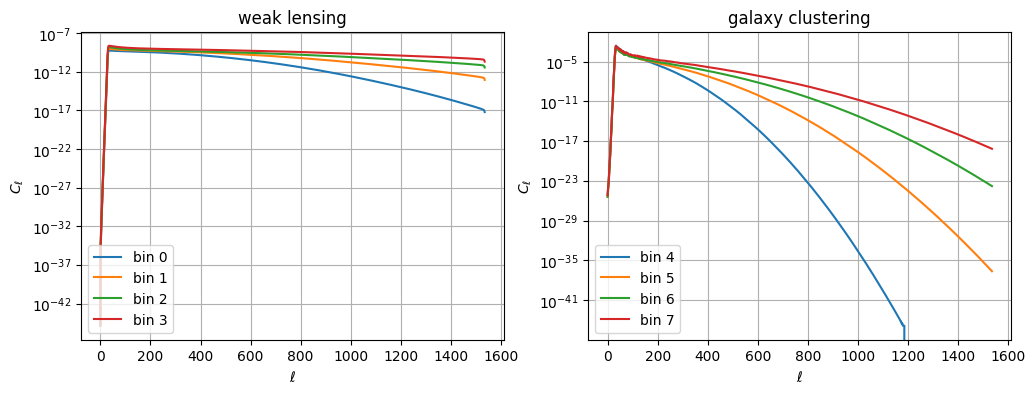

In [6]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)

for i in range(4):
    ax[0].plot(mean_fidu_cls[:,i], label=f"bin {i}")
    
ax[0].set(xscale="linear", yscale="log", title="weak lensing", xlabel=r"$\ell$", ylabel=r"$C_\ell$")
ax[0].grid(True)
ax[0].legend(loc="lower left")
    
for i in range(4,8):
    ax[1].plot(mean_fidu_cls[:,i], label=f"bin {i}")
    
ax[1].set(xscale="linear", yscale="log", title="galaxy clustering", xlabel=r"$\ell$", ylabel=r"$C_\ell$")
ax[1].grid(True)
ax[1].legend(loc="lower left")

# naive criterion

With the naive criterion at l_max 488, the smoothed cls are 5.9506574 times smaller than the raw ones
With the naive criterion at l_max 715, the smoothed cls are 5.943797 times smaller than the raw ones
With the naive criterion at l_max 964, the smoothed cls are 5.9399467 times smaller than the raw ones
With the naive criterion at l_max 1148, the smoothed cls are 5.938142 times smaller than the raw ones
With the naive criterion at l_max 165, the smoothed cls are 5.9932847 times smaller than the raw ones
With the naive criterion at l_max 242, the smoothed cls are 5.9727464 times smaller than the raw ones
With the naive criterion at l_max 316, the smoothed cls are 5.9624653 times smaller than the raw ones
With the naive criterion at l_max 378, the smoothed cls are 5.9569216 times smaller than the raw ones
[0.00443078 0.00485367 0.00481964 0.00608376 1.62299023 0.81909851
 0.64732432 0.73886103]
[7.8424080e-11 9.4108520e-11 9.2793738e-11 1.4785403e-10 1.0522538e-05
 2.6801615e-06 1.673911

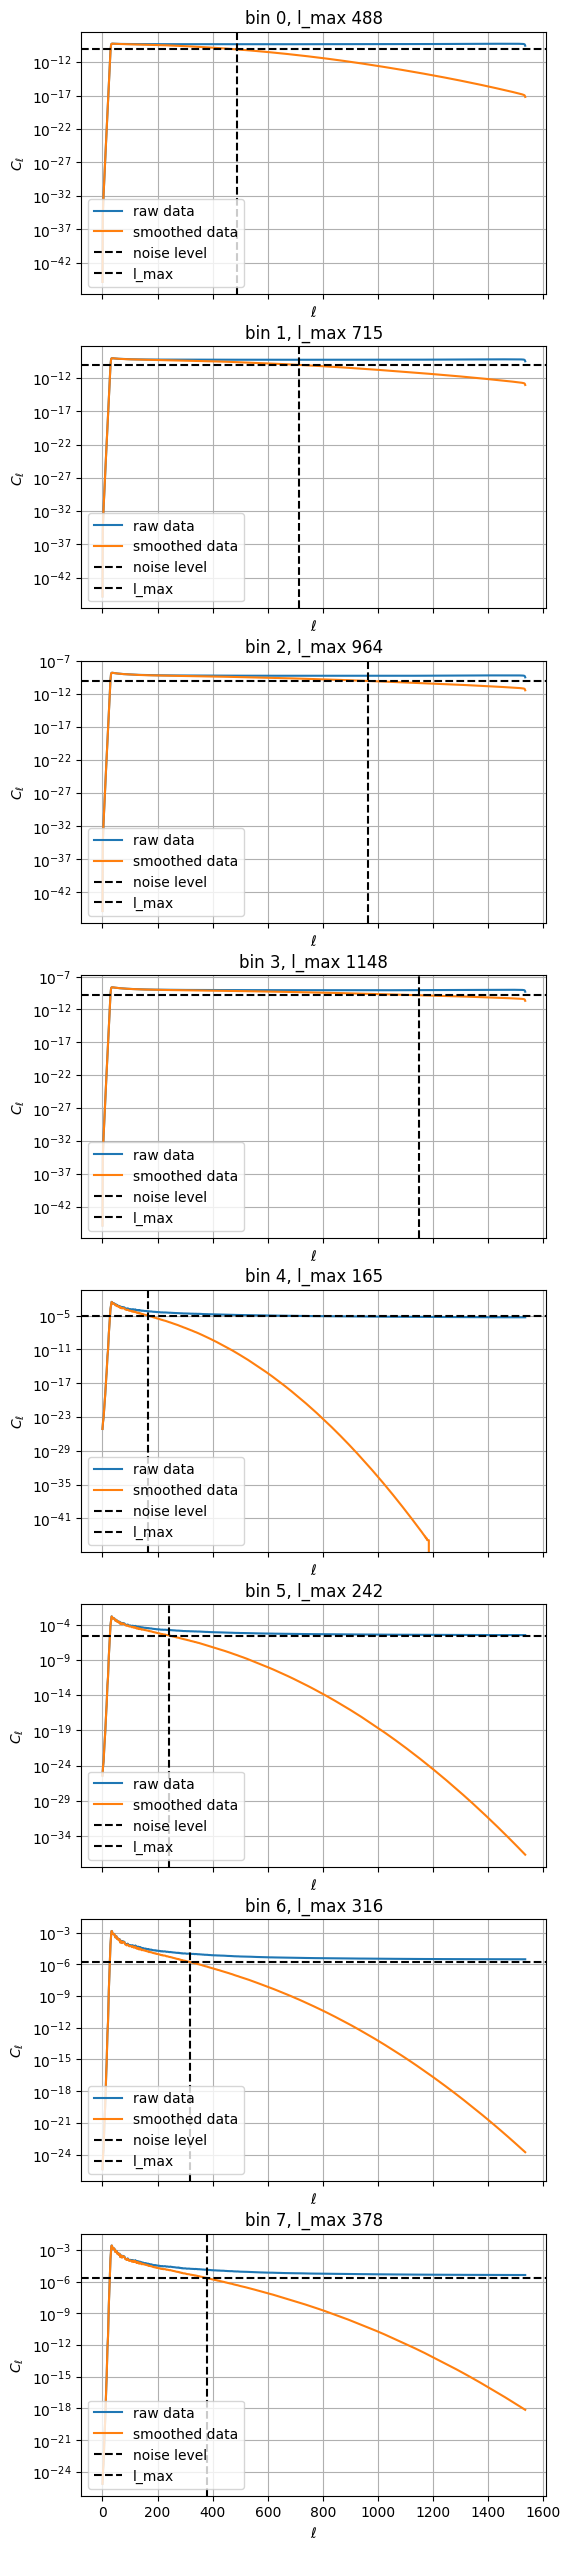

In [10]:
fig, ax = plt.subplots(figsize=(6, 4*n_z), nrows=n_z, sharex=True, sharey=False)

sigmas_naive = []
noises_naive = []
for i in range(n_z):
    l_max = l_maxs[i]
    
    print(
        f"With the naive criterion at l_max {l_max}, the smoothed cls are", 
        mean_fidu_cls_raw[l_max,i]/mean_fidu_cls[l_max,i], 
        "times smaller than the raw ones"
    )
    
    noise_level_cl = mean_fidu_cls[l_max,i]
    noises_naive.append(noise_level_cl)
    
    sigma = np.sqrt(noise_level_cl / hp.nside2pixarea(n_side))
    sigmas_naive.append(sigma)
    
    ax[i].plot(mean_fidu_cls_raw[:,i], label="raw data")
    ax[i].plot(mean_fidu_cls[:,i], label="smoothed data")
    ax[i].axhline(noise_level_cl, color="k", linestyle="--", label="noise level")
    ax[i].axvline(l_max, color="k", linestyle="--", label="l_max")
    ax[i].set(xscale="linear", yscale="log", title=f"bin {i}, l_max {l_max}", xlabel=r"$\ell$", ylabel=r"$C_\ell$")
    ax[i].grid(True)
    ax[i].legend(loc="lower left")
    
sigmas_naive = np.array(sigmas_naive)
noises_naive = np.array(noises_naive)
print(sigmas_naive)
print(noises_naive)

# percentage criterion

With a threshold of 0.01, the smoothed cls are 100.62931 times smaller than the raw ones
With a threshold of 0.01, the smoothed cls are 100.31874 times smaller than the raw ones
With a threshold of 0.01, the smoothed cls are 83.273506 times smaller than the raw ones
With a threshold of 0.01, the smoothed cls are 22.605242 times smaller than the raw ones
With a threshold of 0.01, the smoothed cls are 100.31701 times smaller than the raw ones
With a threshold of 0.01, the smoothed cls are 100.5554 times smaller than the raw ones
With a threshold of 0.01, the smoothed cls are 100.36772 times smaller than the raw ones
With a threshold of 0.01, the smoothed cls are 100.71891 times smaller than the raw ones
[0.00107639 0.00119809 0.00136985 0.00326847 0.26904975 0.14492357
 0.11769442 0.12976879]
[4.6283476e-12 5.7341306e-12 7.4960437e-12 4.2675433e-11 2.8917043e-07
 8.3900922e-08 5.5335072e-08 6.7271209e-08]


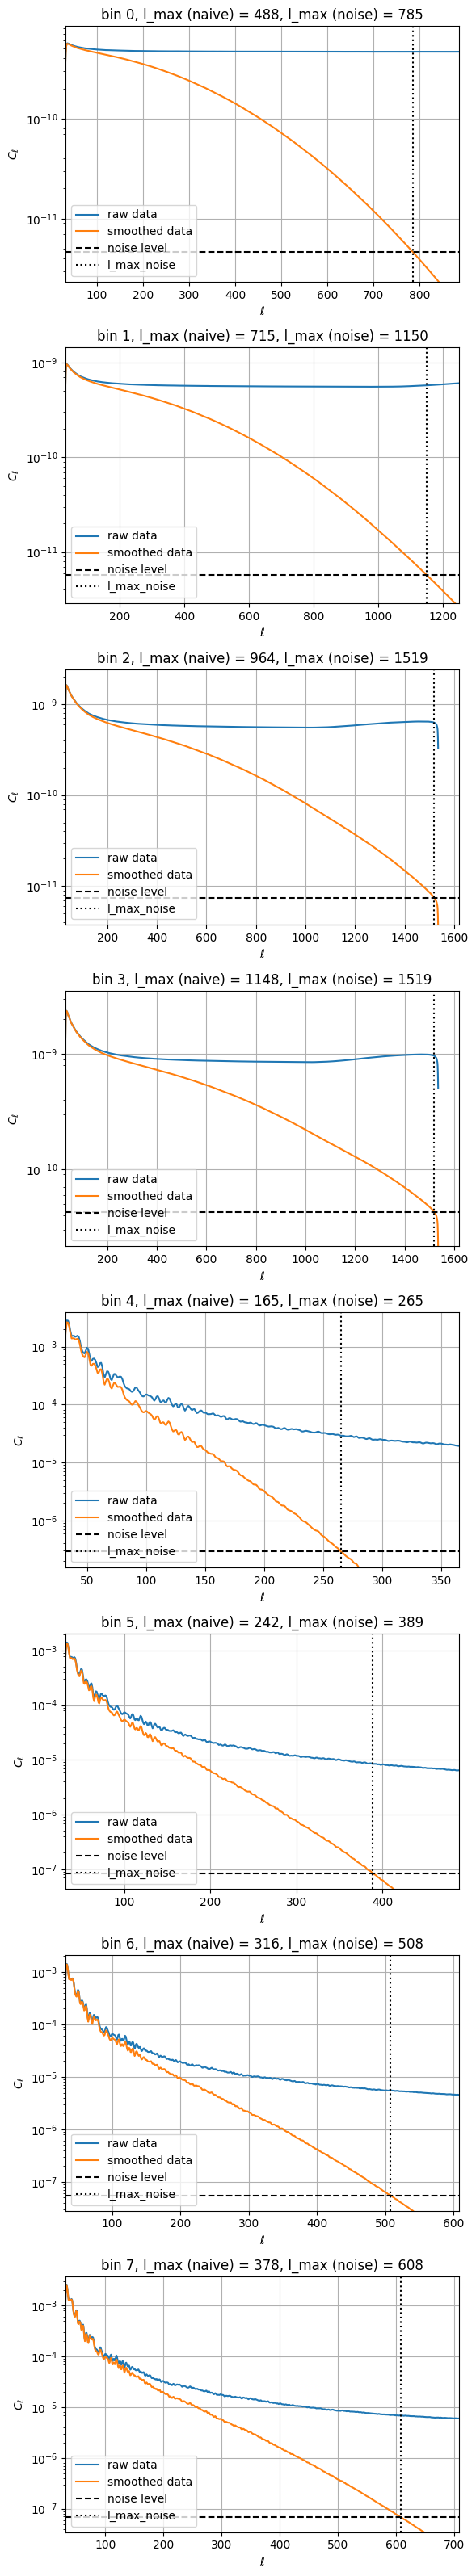

In [30]:
# the noise level is determined to be equal to the value for which the Cl are suppressed this much
# threshold = 0.1
threshold = 0.01
l = np.arange(l_max_global)

fig, ax = plt.subplots(figsize=(6, 4*n_z), nrows=n_z, sharex=False, sharey=False)

sigmas_percent = []
noises_percent = []
for i in range(n_z):
    l_max = l_maxs[i]
    
    # this only works for monotonously decaying functions (which the smoothed Cls are)
    low_pass_fac_cls = scales.gaussian_low_pass_factor_alm(l, l_max)**2
    try:
        l_max_noise = l[low_pass_fac_cls < threshold][0]
    except IndexError:
        l_max_noise = l_max_global - 16
                        
    print(
        f"With a threshold of {threshold}, the smoothed cls are", 
        mean_fidu_cls_raw[l_max_noise,i]/mean_fidu_cls[l_max_noise,i], 
        "times smaller than the raw ones"
    )

    noise_level_cl = mean_fidu_cls[l_max_noise,i]
    noises_percent.append(noise_level_cl)
    
    sigma = np.sqrt(noise_level_cl / hp.nside2pixarea(n_side))
    sigmas_percent.append(sigma)
    
    ax[i].plot(mean_fidu_cls_raw[:,i], label="raw data")
    ax[i].plot(mean_fidu_cls[:,i], label="smoothed data")
    ax[i].axhline(noise_level_cl, color="k", linestyle="--", label="noise level")
    ax[i].axvline(l_max_noise, color="k", linestyle=":", label="l_max_noise")
        
    ax[i].set(
        xscale="linear", 
        yscale="log", 
        title=f"bin {i}, l_max (naive) = {l_max}, l_max (noise) = {l_max_noise}", 
        xlabel=r"$\ell$", 
        ylabel=r"$C_\ell$", 
        xlim=(32, l_max_noise + 100),
        ylim=(0.5 * mean_fidu_cls[32:l_max_noise,i].min(), 1.5 * mean_fidu_cls[32:l_max_noise,i].max()),
    )
    ax[i].grid(True)
    ax[i].legend(loc="lower left")
    
fig.tight_layout()

sigmas_percent = np.array(sigmas_percent)
noises_percent = np.array(noises_percent)
print(sigmas_percent)
print(noises_percent)

# take the normalization of the maps into account

In [ ]:
one = np.random.random(n_pix)
# ones = np.ones(n_pix)
two = 2*one

cls_1 = hp.anafast(one)
cls_2 = hp.anafast(two)

# if you double the map, you 2^2 the Cls
print(cls_2[0]/cls_1[0])
print(cls_2[100]/cls_1[100])

In [ ]:
# the galaxy clustering maps don't get a normalization factor
map_normalization = np.array(conf["analysis"]["normalization"]["lensing"] + 4 * [1])
normalized_sigmas_naive = np.sqrt(noises_naive/map_normalization**2 / hp.nside2pixarea(n_side))
normalized_sigmas_percent = np.sqrt(noises_percent/map_normalization**2 / hp.nside2pixarea(n_side))

print("naive")
print(sigmas_naive)
print(normalized_sigmas_naive)

print(f"\n{threshold*100} percent")
print(sigmas_percent)
print(normalized_sigmas_percent)

# loop through the maps instead

In [ ]:
tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v8/linear_bias_no_smoothing/tfrecords/fiducial/DESy3_fiducial_dmb_????.tfrecord"

conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v8/linear_bias_no_smoothing.yaml"
params = []
# params = ["Om", "s8"]
filename_suffix = "v8"

In [ ]:
conf = files.load_config(conf)

fidu_pipe = FiducialPipeline(
    conf=conf,
    params=params,
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    # apply_norm=False,
    apply_norm=True,
    shape_noise_scale=1.0,
    poisson_noise_scale=1.0,
)

n_side = conf["analysis"]["n_side"]
n_pix = hp.nside2npix(n_side)
data_vec_pix = fidu_pipe.data_vec_pix
n_z = fidu_pipe.n_z_metacal + fidu_pipe.n_z_maglim
l_max_global = 3 * n_side - 1

In [ ]:
fidu_dset = fidu_pipe.get_dset(
    tfr_pattern=tfr_pattern,
    local_batch_size=1,
    noise_indices=10,
    n_readers=1,
    examples_shuffle_buffer=None,
    n_prefetch=2,
    is_eval=True,
)

for data_vector, index in fidu_dset.take(1):
    print(data_vector.shape)

# smoothing layer

In [ ]:
mask_dict = files.get_tomo_dv_masks(conf)
mask = tf.concat([mask_dict["metacal"], mask_dict["maglim"]], axis=1)    
mask = mask.numpy()

smoothing_kwargs = {
    "nside": n_side,
    "indices": data_vec_pix,
    "nest": True,
    "mask": mask,
    "fwhm": fwhm,
    "arcmin": True,
    "n_sigma_support": 3,
    "data_path": ".",
}

smoothing_layer = HealpySmoothing(**smoothing_kwargs)

In [ ]:
n_examples = 10
n_plots = 3
sigmas = np.zeros((n_examples, n_z))

fig, ax = plt.subplots(figsize=(4, n_plots*4), nrows=n_plots)

for i, (dv, index) in tqdm(enumerate(fidu_dset.take(n_examples)), total=n_examples):
    smooth_dv = smoothing_layer(dv)
    
    for j in range(n_z):
        l_max = l_maxs[j]
        
        smooth_map = np.zeros(n_pix)
        smooth_map[data_vec_pix] = smooth_dv[...,j]
        smooth_map = hp.reorder(smooth_map, n2r=True)
        smooth_cls = hp.anafast(smooth_map, lmax=l_max_global)

        savgol_cls = savgol_filter(smooth_cls, window_length=20, polyorder=1)
        noise_level_cl = savgol_cls[l_max]
        
        sigma = np.sqrt(noise_level_cl / hp.nside2pixarea(n_side))
        sigmas[i,j] = sigma
        
        if j == 0 and i < n_plots:
            ax[i].plot(savgol_cls, label="savgol smoothed Cls")
            ax[i].axhline(noise_level_cl, color="k", linestyle="--", label="noise level")
            ax[i].axvline(l_max, color="k", linestyle="--", label="l_max")
            ax[i].set(xscale="linear", yscale="log", title=f"bin {j}, example {i}, l_max {l_max}", xlabel=r"$\ell$", ylabel=r"$C_\ell$")
            ax[i].grid(True)
            ax[i].legend(loc="lower left")

sigmas_from_map = np.mean(sigmas, axis=0)
print(sigmas_from_map)

In [ ]:
print(f"From {n_examples} maps with savgol smoothing on the Cls")
print(sigmas_from_map)

print(f"From the mean Cls")
print(sigmas_naive)

# relationship between the Cls and Gaussian white noise sigma

In [ ]:
sigmas = np.geomspace(2**-4, 2**4, 9)

fig, ax = plt.subplots()
for sigma in sigmas:
    white_noise_map = np.random.normal(loc=0, scale=sigma, size=n_pix)
    # hp.mollview(white_noise_map, title='White noise map')

    white_noise_cl = hp.anafast(white_noise_map, lmax=l_max_global)
    ell = np.arange(len(white_noise_cl))
    predicted_cl = sigma**2*hp.nside2pixarea(n_side)

    ax.plot(ell, white_noise_cl, label=r"$\sigma$" + f' = {sigma:.3f}')
    ax.axhline(predicted_cl, color='k', linestyle='--')

ax.set(xscale="linear", yscale="log", xlabel=r'$\ell$', ylabel=r'$C_\ell$', title="white noise")
ax.legend()

# GRF example

In [ ]:
print(bin_indices)
# index 21 corresponds to weak lensing bin 4
raw_cls = file_dict["fiducial/cls/raw"][0,:,21]
print(raw_cls.shape)

In [ ]:
fwhm_arcmin = 30.0
fwhm = scales.arcmin_to_rad(fwhm_arcmin)

l_naive_smooth = scales.angle_to_ell(fwhm, arcmin=False, method="naive")
print(f"Naive smoothig scale: {l_naive_smooth}")

In [ ]:
l_max = 500

example_map = hp.synfast(cls=raw_cls, nside=n_side)
smoothed_map = hp.smoothing(example_map, fwhm=fwhm)
smoothed_cls = hp.anafast(smoothed_map, lmax=l_max_global)

noise_level_cl = savgol_filter(smoothed_cls, window_length=20, polyorder=1)[l_max]
sigma = np.sqrt(noise_level_cl / hp.nside2pixarea(n_side))
noise_map = np.random.normal(loc=0.0, scale=sigma, size=n_pix)
noise_cls = hp.anafast(noise_map, lmax=l_max_global)

noisy_map = smoothed_map + noise_map
noisy_cls = hp.anafast(noisy_map, lmax=l_max_global)

vmin, vmax = noisy_map.min(), noisy_map.max()

plt.figure(figsize=(12,12))
hp.mollview(smoothed_map, title='smoothed map', min=vmin, max=vmax, sub=(2,2,1))
hp.mollview(noisy_map, title='noisy map', min=vmin, max=vmax, sub=(2,2,2))

hp.gnomview(smoothed_map, title='smoothed map', min=vmin, max=vmax, sub=(2,2,3))
hp.gnomview(noisy_map, title='noisy map', min=vmin, max=vmax, sub=(2,2,4))

fig, ax = plt.subplots(figsize=(12,8))
ell = np.arange(len(raw_cls))
ax.plot(ell, raw_cls, label='raw')
ax.plot(ell, smoothed_cls, label='smoothed')
ax.plot(ell, noise_cls, label='noise')
ax.plot(ell, noisy_cls, label='noisy')
# ax.plot(ell, smoothed_cls + noise_cls, label='smoothed + noise')
ax.axvline(l_naive_smooth, color='k', linestyle=':', label='naive l_max')
ax.axvline(l_max, color='k', linestyle='--', label='set l_max')
# ax.axhline(noise_level_cl, color='k', linestyle='--', label='noise level')
ax.set(
    xlabel=r"$\ell$", 
    ylabel=r"$C_\ell$", 
    xscale="linear", 
    yscale="log", 
    xlim=(l_min_global, 2*l_naive_smooth), 
    ylim=(1e-13, 1e-8),
    title=f"fwhm = {fwhm_arcmin} arcmin"
)
ax.grid(True)
ax.legend(loc="lower left");